In [1]:
from keras_tft import TFTForecaster, plot_probabilistic_forecast, preprocess_timeseries, timeseries_cv, plot_feature_importance

The dataset tracks the weekly sales of many Walmart stores from February 5, 2010 to October 26, 2012 as the forecasting scenario. This dataset is released under the Creative Commons 0 license. Although the original dataset tracked thousands of stores, we’ll use a subset of only four stores.

In [2]:
FORECAST_HORIZON = 2
INPUT_LEN = 16  # 4 months of history 
EPOCHS = 15 # Number of epochs for training

# Walmart sales dataset
path = 'data/walmart_sales_small.csv'

In [3]:
CUTOFF_DATE = '2012-08-01'
# Preprocess data
# The function now returns history and the full prediction input (history + future)
data, pred_input, test_df, scaler = preprocess_timeseries(
    cutoff_date=CUTOFF_DATE,
    file_path=path,
    forecast_horizon=FORECAST_HORIZON,
    static_covariates=['Store'],     
)

data.head()

,id_column,timestamp,y,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag
0,1,2010-02-05,0.390823,-1.594146,-1.433373,0.436887,0.903796,0
143,2,2010-02-05,0.538659,-1.732826,-1.433373,0.427909,1.125108,0
286,3,2010-02-05,0.036570,-1.371735,-1.433373,0.523818,0.154583,0
429,4,2010-02-05,0.538106,-1.499294,-1.372115,-1.774048,1.428651,0
144,2,2010-02-12,0.538905,-1.844032,-1.489919,0.431706,1.125108,1


In [4]:
pred_input.tail()

,id_column,timestamp,y,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag
567,1,2012-10-19,0.0,0.084404,0.974529,0.758895,-0.652496,0
568,2,2012-10-26,0.0,0.203460,0.767195,0.749823,-1.061620,0
569,1,2012-10-26,0.0,0.162248,0.767195,0.759379,-0.652496,0
570,3,2012-10-26,0.0,0.522031,0.767195,0.851916,-1.199686,0
571,4,2012-10-26,0.0,-0.198843,0.786043,-1.649964,-3.387429,0


In [5]:
# Initialize TFT Forecaster model
model = TFTForecaster(
    input_chunk_length=INPUT_LEN,
    output_chunk_length=FORECAST_HORIZON,
    quantiles=[0.1, 0.5, 0.9]
)

In [6]:
# Train the model
model.fit(
    data,
    target_col="y",
    exogenous=["Temperature", "Fuel_Price", "CPI",
                     "Unemployment", "Holiday_Flag"],
    static_cov_cols=['id_column'],
    epochs=EPOCHS,
    use_early_stopping=True, early_stopping_patience=2
)

Training on 452 samples.
past-covariates: 6 | future-covariates: 5 | static-covariates: 1
Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 820ms/step - loss: 0.3203 - learning_rate: 0.0010
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1564 - learning_rate: 0.0010
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1209 - learning_rate: 0.0010
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1041 - learning_rate: 0.0010
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1001 - learning_rate: 0.0010
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0953 - learning_rate: 0.0010
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0924 - learning_rate: 0.0010
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0909 - learning_rate: 0.0010
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0819 - learning_rate: 0.0010
Epoch 10/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0782 - learning_rate: 0.0010
Epoch 1

In [7]:
# Forecast
forecast = model.predict(pred_input)
forecast

,q10,q50,q90,id_column
0,0.312392,0.369798,0.434567,1
1,0.312375,0.368270,0.436162,1
2,0.351484,0.397108,0.457504,2
3,0.351455,0.396121,0.458992,2
4,-0.046921,0.000062,0.046609,3
5,-0.045818,0.001066,0.047593,3
6,0.480984,0.540211,0.619926,4
7,0.481039,0.541915,0.629778,4


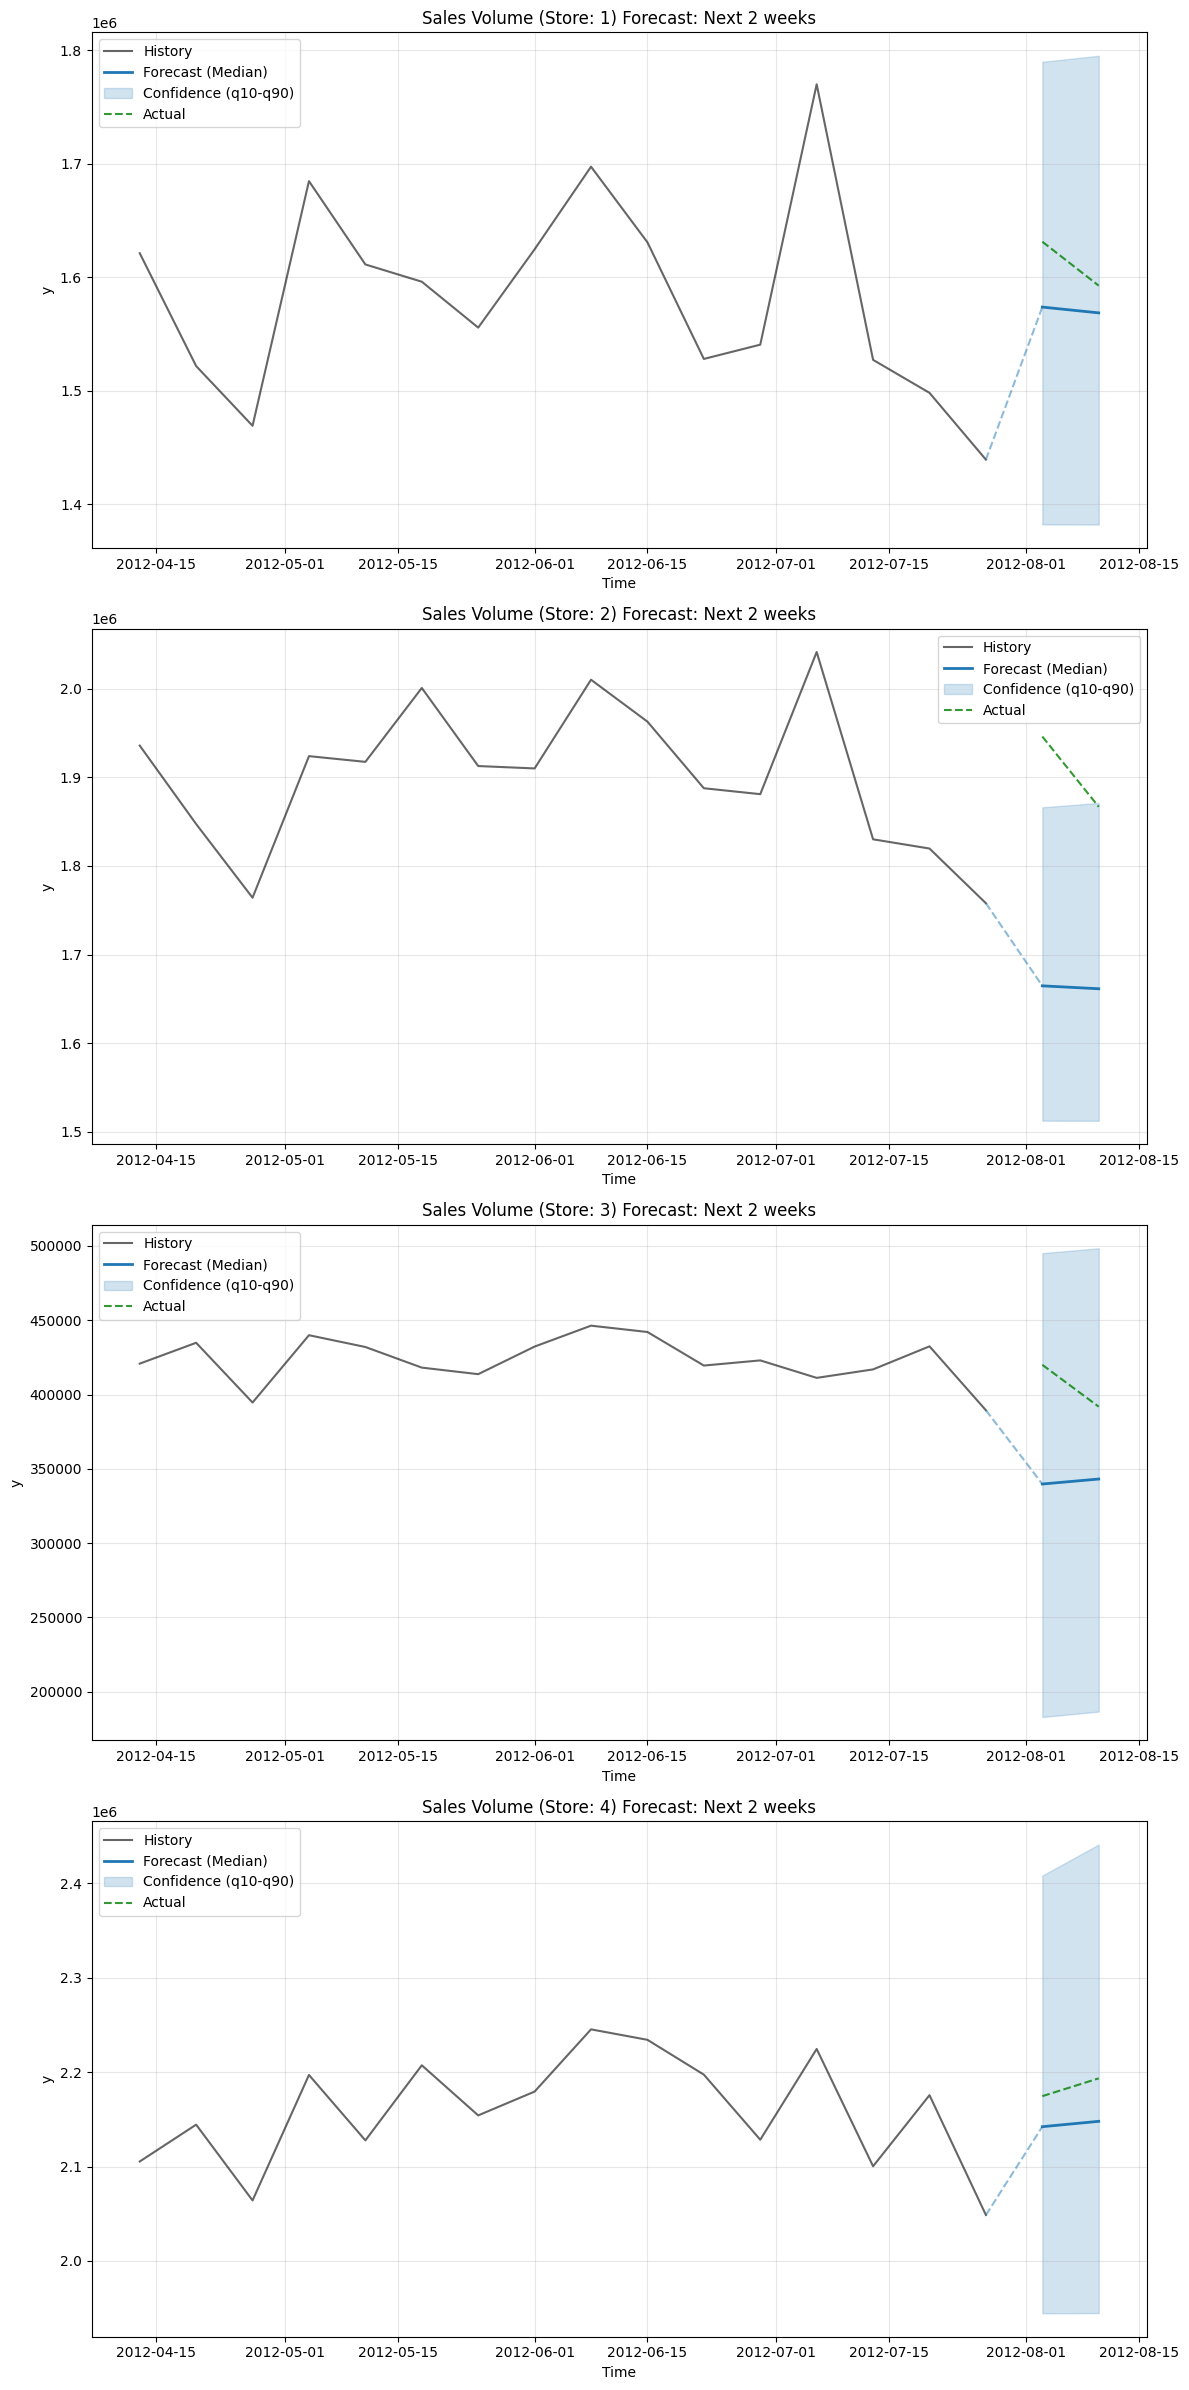

In [8]:
# Plot the probabilistic forecast
plot_probabilistic_forecast(
    history_df=data,
    id_col_name="Store",
    forecast_df=forecast,
    target_col="y",
    scaler=scaler,
    actual_df=test_df,
    timeseries_name="Sales Volume",
    time_col="timestamp",
    history_length=INPUT_LEN
)

In [9]:
results = timeseries_cv(
    model=model, # Pass the instantiated TFTForecaster model object
    df=data,
    num_windows=5,
    future_cov_cols=["Temperature", "Fuel_Price", "CPI",
                     "Unemployment", "Holiday_Flag"],
    forecast_horizon=FORECAST_HORIZON
)


CROSS-VALIDATION: 2012-06-01 to 2012-07-27 (Test Ends)
Forecast Horizon: 2 weeks | Windows: 5

Window   1 | Date: 2012-05-25 | Train:  480 weeks | RMSE:   0.25 | MAE:   0.21 | MAPE: 325.45%
Window   2 | Date: 2012-06-08 | Train:  488 weeks | RMSE:   0.38 | MAE:   0.33 | MAPE: 78.10%
Window   3 | Date: 2012-06-22 | Train:  496 weeks | RMSE:   0.28 | MAE:   0.23 | MAPE: 364.92%
Window   4 | Date: 2012-07-06 | Train:  504 weeks | RMSE:   0.24 | MAE:   0.17 | MAPE: 501.07%
Window   5 | Date: 2012-07-20 | Train:  512 weeks | RMSE:   0.31 | MAE:   0.24 | MAPE: 433.40%

CROSS-VALIDATION SUMMARY
Total Windows: 5
Overall RMSE: 0.29
Overall MAE:  0.24
Overall MAPE: 340.59%



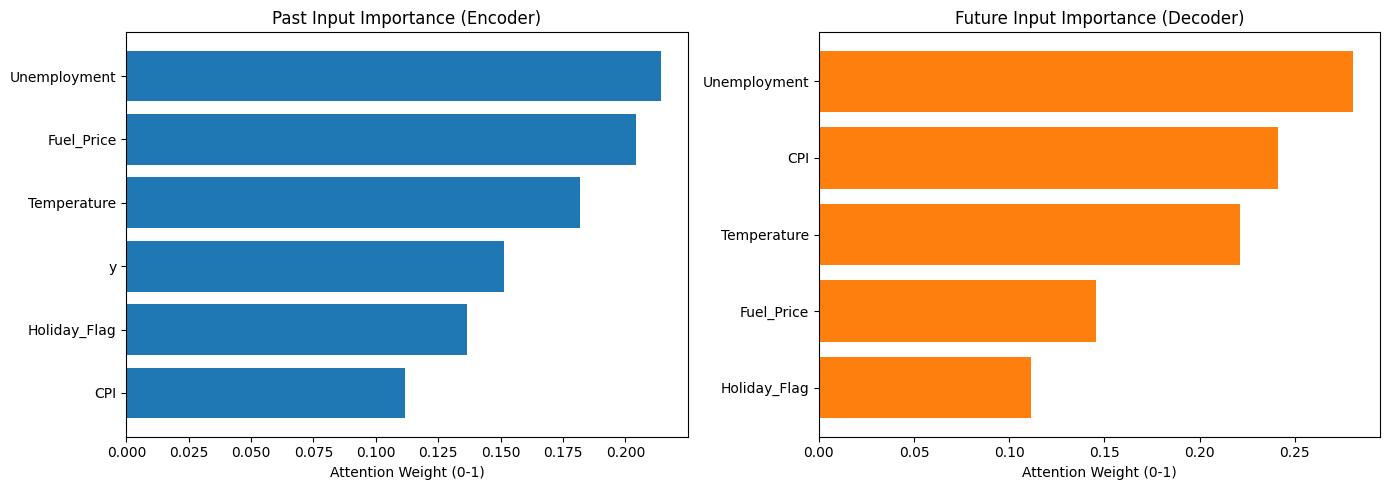

In [10]:
# Feature Importance Analysis

# Extract feature importance
importance_results = model.get_feature_importance(data)

# Plot importance (handles printing and plotting internally)
plot_feature_importance(importance_results)